#06 2개의 층을 연결합니다. -다층 신경망

## 06-1 신경망 알고리즘을 벡터화하여 한 번에 전체 샘플을 사용합니다

넘파이, 머신러닝, 딥러닝 패키지들은 다차원의 배열 계싼을 빠르게 수행할 수 있습니다. 이런 기능을 벡터화(vecotrization)된 연산이라고 합니다.

지금까지 구해왔던 z = x * self.w 에서 두 벡터의 연산이 * 기호로 단순하게 이루어 졌는데 이를 풀어쓰면 $x*w = x_1w_1 + x_2w_2...x_nw_n$이 됩니다. 이를 점 곱(dot product) 또는 스칼라 곱이라고 합니다


In [0]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

cancer = load_breast_cancer()
x = cancer.data
y = cancer.target

x_train_all, x_test, y_train_all, y_test = train_test_split(x,y,stratify=y,test_size=0.2,
                                                            random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train_all, y_train_all,
                                                  stratify=y_train_all, test_size=0.2, random_state=42)

In [0]:
print(x_train.shape, x_val.shape)

(364, 30) (91, 30)


In [0]:
class SingleLayer:

  def __init__(self, learning_rate = 0.1, l1=0, l2=0):
    self.w = None
    self.b = None
    self.losses = []
    self.val_losses = []
    self.w_history = []
    self.lr = learning_rate
    self.l1 = l1
    self.l2 = l2
  
  def forpass(self, x):
    return np.dot(x, self.w) + self.b
  
  def backprop(self, x, err):
    m = len(x)
    w_grad = np.dot(x.T, err) / m
    b_grad = np.sum(err)/m

    return w_grad, b_grad

  
  def activation(self, z):
    return (1 / (1 + np.exp(-z)))

  def fit(self, x, y, epochs=100, x_val=None, y_val=None):
    y = y.reshape(-1,1)
    y_val = y_val.reshape(-1,1)
    m = len(x)
    self.w = np.ones((x.shape[1],1))
    self.b = 0
    self.w_history.append(self.w.copy())
    np.random.seed(42)
    for i in range(epochs):
      z = self.forpass(x)
      a = self.activation(z)
      err = -(y-a)
      w_grad, b_grad = self.backprop(x,err)

      w_grad += (self.l1 * np.sign(self.w) + self.l2*self.w) / m
      self.w -= self.lr * w_grad
      self.b -= self.lr*b_grad

      self.w_history.append(self.w.copy())
      a = np.clip(a,1e-10, 1-1e-10)

      loss = np.sum(-(y*np.log(a)+(1-y)*np.log(1-a)))
      self.losses.append((loss+self.reg_loss()) / m)
      self.update_val_loss(x_val, y_val)


  def update_val_loss(self, x_val, y_val):
    z = self.forpass(x_val)
    a = self.activation(z)
    a = np.clip(a, 1e-10, 1-1e-10)
    val_loss =np.sum( -(y_val*np.log(a)+(1-y_val)*np.log(1-a)))
    self.val_losses.append((val_loss+ self.reg_loss())/len(y_val) )
  
  def reg_loss(self):
    return self.l1 * np.sum(np.abs(self.w)) + self.l2 / 2 * np.sum(self.w**2)

  def predict(self, x):
    z = [self.forpass(x_i) for x_i in x]
    return np.array(z) > 0
  
  def score(self, x, y):
    return np.mean(self.predict(x) == y.reshape(-1,1))

In [0]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_val_scaled = scaler.transform(x_val)

In [0]:
single_layer = SingleLayer(l2 = 0.01)
single_layer.fit(x_train_scaled, y_train, x_val = x_val_scaled, y_val = y_val, epochs=10000)
single_layer.score(x_val_scaled, y_val)

0.978021978021978

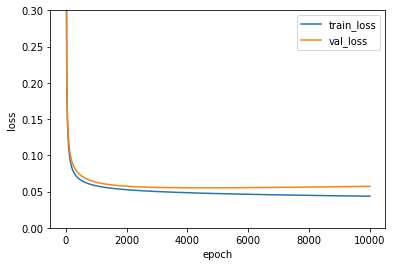

In [0]:
plt.ylim(0, 0.3)
plt.plot(single_layer.losses)
plt.plot(single_layer.val_losses)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss','val_loss'])
plt.show()

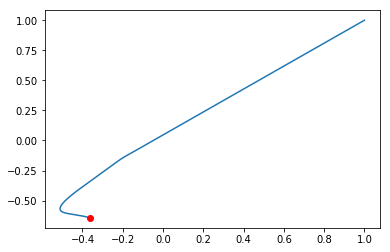

In [0]:
w2 = []
w3 = []

for w in single_layer.w_history:
  w2.append(w[2])
  w3.append(w[3])

plt.plot(w2, w3)
plt.plot(w2[-1], w3[-1], 'ro')
plt.show()

### 결론 : 배치경사법을 사용하면 가중치를 경로가 다소 부드러운 곡선의 형태를 뛰고 손실값도 안정적으로 수렴됩니다. 하지만 배치 경사 하강법은 매번 전체 훈련 세트를 사용하므로 연산 비용이 많이 들고 최솟값에 수렴하는 시간 도 많이 걸립니다.

## 06-2 2개의 층을 가진 신경망을 구현합니다

오타 : p170 알고리도즘으로 



In [0]:
class DualLayer(SingleLayer):
  
  def __init__(self, units=10, learning_rate=0.1, l1=0, l2=0):
    self.units = units # 은닉층 뉴런 개수
    self.w1 = None     # 은닉층의 가중치
    self.b1 = None     # 은닉층의 절편
    self.w2 = None     # 출력층의 가중치
    self.b2 = None     # 출력층의 절편
    self.a1 = None     # 은닉층의 활성화 출력
    self.losses = []
    self.val_losses = []
    self.lr = learning_rate
    self.l1 = l1
    self.l2 = l2
  
  def forpass(self, x):
    z1 = np.dot(x, self.w1) + self.b1
    self.a1 = self.activation(z1)
    z2 = np.dot(self.a1, self.w2) + self.b2
    return z2
  def activation(self, z):
    return (1 / (1 + np.exp(-z)))
  
  def backprop(self, x, err):
    m = len(x)
    
    w2_grad = np.dot(self.a1.T, err) / m
    b2_grad = np.sum(err) / m
    
    err_to_hidden = np.dot(err, self.w2.T) * self.a1 * (1 - self.a1)
    
    w1_grad = np.dot(x.T, err_to_hidden) / m
    b1_grad = np.sum(err_to_hidden, axis=0) / m
    
    return w1_grad, b1_grad, w2_grad, b2_grad
  
  def init_weights(self, n_features):
    self.w1 = np.ones((n_features, self.units))
    self.b1 = np.zeros(self.units)
    self.w2 = np.ones((self.units, 1))
    self.b2 = 0
  def fit(self, x, y, epochs=100, x_val=None, y_val=None):
    y = y.reshape(-1, 1)
    y_val = y_val.reshape(-1, 1)
    m = len(x)
    self.init_weights(x.shape[1])
    
    for i in range(epochs):
      a = self.training(x, y, m)
      a = np.clip(a, 1e-10, 1-1e-10)
      
      loss = np.sum(-(y*np.log(a) + (1-y)*np.log(1-a)))
      self.losses.append((loss + self.reg_loss()) / m)
      self.update_val_loss(x_val, y_val)
    
  def training(self, x, y, m):
    z = self.forpass(x) #정방향
    a = self.activation(z) #활성화 함수
    err = -(y - a) # 오차 계산
    # 오차를 역전파하여 그레이디언트를 계산합니다
    w1_grad, b1_grad, w2_grad, b2_grad = self.backprop(x, err)
    # 그레이디언트에서 페널티 항의 미분값을 뺍니다.
    w1_grad += (self.l1 * np.sign(self.w1) + self.l2 * self.w1) / m
    w2_grad += (self.l1 * np.sign(self.w2) + self.l2 * self.w2) / m
    
    self.w1 -= self.lr * w1_grad
    self.b1 -= self.lr * b1_grad
    
    self.w2 -= self.lr * w2_grad
    self.b2 -= self.lr * b2_grad
    
    return a
  def reg_loss(self):
    return self.l1 * (np.sum(np.abs(self.w1)) + np.sum(np.abs(self.w2))) + self.l2 / 2 * (np.sum(self.w1**2) + np.sum(self.w2**2))
  
  def update_val_loss(self, x_val, y_val):
    z = self.forpass(x_val)
    a = self.activation(z)
    a = np.clip(a, 1e-10, 1-1e-10)
    val_loss =np.sum( -(y_val*np.log(a)+(1-y_val)*np.log(1-a)))
    self.val_losses.append((val_loss+ self.reg_loss())/len(y_val) )
  
  def predict(self, x):
    z = [self.forpass(x_i) for x_i in x]
    return np.array(z) > 0
  
  def score(self, x, y):
    return np.mean(self.predict(x) == y.reshape(-1,1))

In [6]:
dual_layer = DualLayer(l2=0.01)
dual_layer.fit(x_train_scaled, y_train, x_val=x_val_scaled, y_val=y_val, epochs=20000)
dual_layer.score(x_val_scaled, y_val)

0.978021978021978

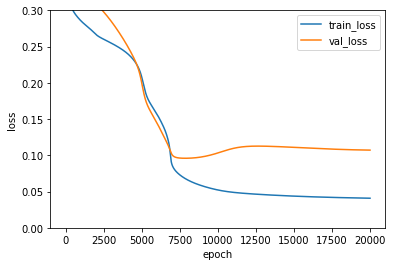

In [7]:
plt.ylim(0, 0.3)
plt.plot(dual_layer.losses)
plt.plot(dual_layer.val_losses)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

In [0]:
# 학습하는데 7500 회정도는 해야 하는 것을 볼 수 있다. 
# 이는 학습해야 하는 가중치의 갯수가 31개에서 321개로 증개해서 그렇다.
# 가중치 초기화를 개선해서 학습 속도를 향상 시켜보자

class RandomInitNetwork(DualLayer):
  def init_weights(self, n_features):
    np.random.seed(42)
    self.w1 = np.random.normal(0, 1, (n_features, self.units))
    self.b1 = np.zeros(self.units)
    self.w2 = np.random.normal(0, 1, (self.units, 1))
    self.b2 = 0

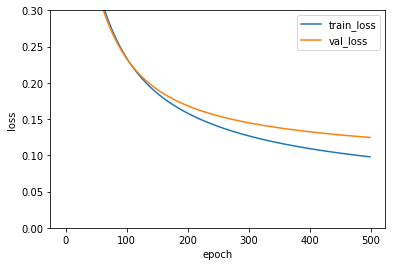

In [11]:
random_init_net = RandomInitNetwork(l2=0.01)
random_init_net.fit(x_train_scaled, y_train, x_val=x_val_scaled, y_val=y_val, epochs=500)

#오타 dual_layer -> random_init_net

plt.ylim(0, 0.3)
plt.plot(random_init_net.losses)
plt.plot(random_init_net.val_losses)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

## 06-3 미니 배치를 사용하여 모델을 훈련합니다.

확률적 경사 하강법 + 배치 경사 하강법 = 미니 배치(mini batch) 경사 하강법이 널리 사용됩니다.
중요한 것은 미니 배치의 최적값은 정해진 것이 아니라는 점입니다. 미니 배치의 크기도 하이퍼파라미터이고 튜닝의 대상입니다.

In [0]:
class MinibatchNetwork(RandomInitNetwork):
  
  def __init__(self, units=10, batch_size=32, learning_rate=0.1, l1=0, l2=0):
    super().__init__(units, learning_rate, l1, l2)
    self.batch_size = batch_size
  def gen_batch(self, x, y):
      length = len(x)
      bins = length // self.batch_size # 미니 배치 횟수
      if length % self.batch_size:
        bins += 1
      indexes = np.random.permutation(np.arange(len(x)))
      
      x = x[indexes]
      y = y[indexes]
      
      for i in range(bins):
        start = self.batch_size * i
        end = self.batch_size * (i+1)
        yield x[start:end], y[start:end]
  def fit(self, x, y, epochs=100, x_val=None, y_val=None):
    y = y.reshape(-1, 1)
    self.init_weights(x.shape[1])
    np.random.seed(42)
    
    for i in range(epochs):
      loss = 0
      for x_batch, y_batch in self.gen_batch(x,y):
        y_batch = y_batch.reshape(-1, 1)
        m = len(x_batch)
        a = self.training(x_batch, y_batch, m)
        
        a = np.clip(a, 1e-10, 1-1e-10)
        
        loss += np.sum(-(y_batch*np.log(a) + (1-y_batch)*np.log(1-a)))
      
      self.losses.append((loss + self.reg_loss()) / len(x))
      self.update_val_loss(x_val, y_val)
    

In [32]:
minibatch_net = MinibatchNetwork(l2=0.01, batch_size=32)
minibatch_net.fit(x_train_scaled, y_train, x_val=x_val_scaled, y_val=y_val, epochs=500)
minibatch_net.score(x_val_scaled, y_val)

0.978021978021978

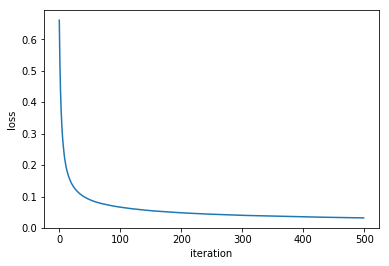

In [33]:
plt.plot(minibatch_net.losses)
#plt.plot(minibatch_net.val_losses)
plt.ylabel('loss')
plt.xlabel('iteration')
#plt.legend(['train_loss', 'val_loss'])
plt.show()

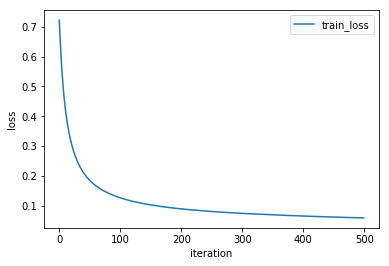

In [34]:
minibatch_net = MinibatchNetwork(l2=0.01, batch_size=128)
minibatch_net.fit(x_train_scaled, y_train, x_val=x_val_scaled, y_val=y_val, epochs=500)
minibatch_net.score(x_val_scaled, y_val)

plt.plot(minibatch_net.losses)
#plt.plot(minibatch_net.val_losses)
plt.ylabel('loss')
plt.xlabel('iteration')
plt.legend(['train_loss', 'val_loss'])
plt.show()

배치의 크기가 커지면 학습 속도는 느려지지만 그래프는 조금 더 안정적으로 바뀌었습니다.
일반적으로 미니 배치의 크기는 32~512개 사이의 값을 지정합니다.
마지막으로 사이킷런을 사용하여 동일한 구조의 신경망 모델을 만들어보겠습니다.

In [0]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(hidden_layer_sizes=(10, ), activation='logistic',
                   solver='sgd', alpha=0.01, batch_size=32,
                   learning_rate_init = 0.1, max_iter=500)

In [38]:
mlp.fit(x_train_scaled, y_train)
mlp.score(x_val_scaled, y_val)

0.989010989010989